In [ ]:
!pip install tensorflow

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:
!pip show keras

Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 4826 files belonging to 5 classes.
Using 3861 files for training.
Found 4826 files belonging to 5 classes.
Using 965 files for validation.
Found 666 files belonging to 5 classes.
Class names: ['Cobra_Bhujangasana', 'DownwardDog_AdhoMukhaShanasana', 'RevolvedTriangle_ParivrttaTrikonasana', 'Tree_Vrikshasana', 'Warrior2_Virabhadrasana']


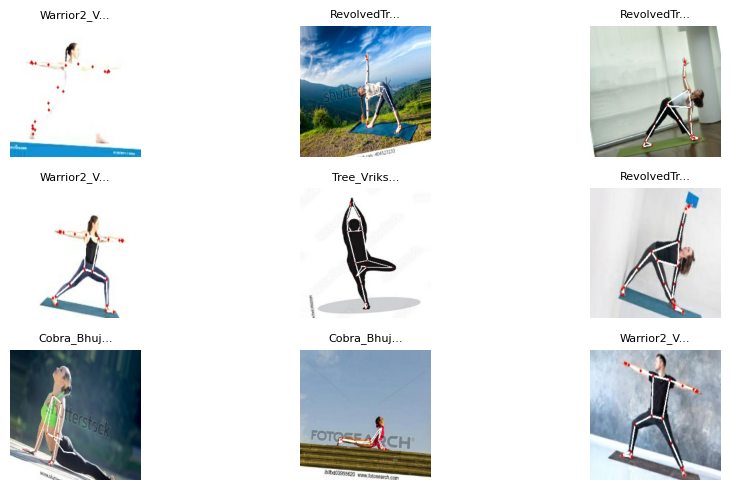

In [ ]:
# Define paths to your dataset
train_val_dir = "/content/drive/MyDrive/SKELETONIZED_TRAIN"  # Training and validation dataset path (split : 80 | 20)
test_dir = "/content/drive/MyDrive/SKELETONIZED_TEST"  # Test dataset path (no split)

# Set parameters
img_size = (224, 224)  # Resize images to 224 x 224
batch_size = 32  # Number of images per batch

# Load Training Dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,  # 80% training, 20% validation
    subset="training",
    seed=123
)

# Load Validation Dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
)

# Display class names
class_names = train_dataset.class_names
classes = len(class_names)
print("Class names:", class_names)

# Display some images from the training set
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Use smaller font size and wrap long names
        title = class_names[labels[i].numpy()]
        plt.title(title[:10] + "..." if len(title) > 10 else title, fontsize=8)  # Truncate long names

        plt.axis("off")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
# Check if TensorFlow detects a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {gpus}")
    print(f"GPU Name: {tf.test.gpu_device_name()}")
else:
    print("❌ No GPU found. Running on CPU.")

✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Name: /device:GPU:0


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Load model without the top classification layer
base_model = EfficientNetB0(weights='imagenet', input_shape=(224, 224, 3), include_top = False)

# Freeze early layers but keep last block trainable
for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers
    layer.trainable = False

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(len(class_names), activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Print summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_7[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_8[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,838,056 (18.46 MB)

 Trainable params: 2,139,445 (8.16 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [ ]:
history = model.fit(train_dataset , validation_data = val_dataset , epochs = 25)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 248ms/step - accuracy: 0.9947 - loss: 0.0171 - val_accuracy: 0.9990 - val_loss: 0.0046
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.9952 - loss: 0.0154 - val_accuracy: 0.9979 - val_loss: 0.0058
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 238ms/step - accuracy: 0.9933 - loss: 0.0188 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9971 - loss: 0.0086 - val_accuracy: 0.9990 - val_loss: 0.0030
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - accuracy: 0.9972 - loss: 0.0119 - val_accuracy: 0.9990 - val_loss: 0.0030
Epoch 6/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.9976 - loss: 0.0096 - val_accuracy: 0.9979 - val_loss: 0.0030
Epoch 7/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.9972 - loss: 0.0074 - val_accuracy: 0.9990 - val_loss: 0.0035
Epoch 8/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9976 - loss: 0

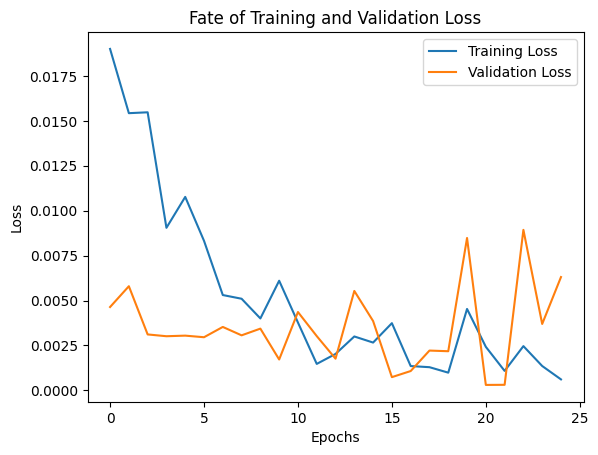

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fate of Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# Initialize lists to store all predictions and true labels
all_predicted_labels_model = []
all_true_labels_model= []

# Loop through the test dataset in batches
for test_images, test_labels in test_dataset:
    # Make predictions on the current batch
    predictions_model = model.predict(test_images)

    # Convert predictions to class labels
    predicted_labels_model = tf.argmax(predictions_model, axis=1)

    # Append predictions and true labels to the lists
    all_predicted_labels_model.extend(predicted_labels_model.numpy())
    all_true_labels_model.extend(test_labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_true_labels_model, all_predicted_labels_model)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Test Accuracy: 99.40%


In [ ]:
model.save("Revised_EfficientNetB0.h5")

In [ ]:
model.save("Revised_EfficientNetB0.keras")